In [ ]:
# Load Library
from google.colab import drive

import time

import random

import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error

import pandas as pd

import matplotlib.pyplot as plt

seed = 1234
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

Mount the drive

In [ ]:
drive.mount('/content/drive/')
path = '/content/drive/My Drive/Colab Notebooks/ESC597/Deep Learning/'

Mounted at /content/drive/


Load the data

In [ ]:
time_start = time.time()

filename = 'POROSITY'

xdf1 = np.loadtxt('{}{}_data1.txt'.format(path, filename)) #Time signals usesd as input to the ML
ydf1 = np.loadtxt('{}{}_info1_reg.txt'.format(path, filename)) #Category Label vector

xdf2 = np.loadtxt('{}{}_data2.txt'.format(path, filename)) #Time signals usesd as input to the ML
ydf2 = np.loadtxt('{}{}_info2_reg.txt'.format(path, filename)) #Category Label vector

xdf = np.concatenate((xdf1, xdf2), axis=0)
ydf = np.concatenate((ydf1[:, 0], ydf2[:, 0]), axis=0)

time_taken = time.time() - time_start
print('\nTotal time taken loading data (in seconds): {:.2f}'.format(time_taken))


Total time taken loading data (in seconds): 4.34


Split the data into training and validation datsets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(xdf, ydf, test_size = 0.1, random_state = seed, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.11, random_state = seed, shuffle=True)

print("X_train Size:" + str(X_train.shape))
print("X_val Size:" + str(X_val.shape))
print("X_test Size:" + str(X_test.shape))

print("y_train Size:" + str(y_train.shape))
print("y_val Size:" + str(y_val.shape))
print("y_test Size:" + str(y_test.shape))

X_train Size:(1600, 500)
X_val Size:(198, 500)
X_test Size:(200, 500)
y_train Size:(1600,)
y_val Size:(198,)
y_test Size:(200,)


Normalize the data

In [ ]:
scaler_X = MinMaxScaler((-1, 1))

X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

scaler_y = MinMaxScaler((0, 1))

y_train = scaler_y.fit_transform(y_train.reshape(-1,1))
y_val = scaler_y.transform(y_val.reshape(-1,1))
y_test = scaler_y.transform(y_test.reshape(-1,1))

In [ ]:
# Details of input & output data

print("Training input data range: \nFrom " + str(np.min(X_train)) + " to " + str(np.max(X_train)))
print("Testing input data range: \nFrom " + str(np.min(X_test)) + " to " + str(np.max(X_test)))

print("Training output data range: \nFrom " + str(np.min(y_train)) + " to " + str(np.max(y_train)))
print("Testing output data range: \nFrom " + str(np.min(y_test)) + " to " + str(np.max(y_test)))

Training input data range: 
From -1.0 to 1.0000000000000004
Testing input data range: 
From -1.805204349501322 to 1.734526934223761
Training output data range: 
From 0.0 to 1.0
Testing output data range: 
From 0.09090909090909091 to 1.0


Define MLP

In [ ]:
#, kernel_regularizer=keras.regularizers.l2(l=0.05)
#x = layers.Dropout(0.2)(x)
def MLP(input_shape, hidden_layers, kernel_std, bias, output_activation, seed): 

  kernelInitializer = tf.keras.initializers.RandomNormal(
                      mean = 0.0, stddev = kernel_std, seed = seed) # Define the kernel initializer used for the initialization of weights in each layer
  biasInitializer = tf.keras.initializers.Constant(value = bias)# Define the bias initializer used for the initialization of the bias vector in each layer

  # Define inputs
  X_train = layers.Input(shape=(input_shape),name='X_train')   

  # Define hidden layers
  for i in range(len(hidden_layers)):
      if i == 0:
        x = layers.Dense(hidden_layers[i], kernel_initializer = kernelInitializer, bias_initializer = biasInitializer, activation="relu")(X_train)
      else:
        x = layers.Dense(hidden_layers[i], kernel_initializer = kernelInitializer, bias_initializer = biasInitializer, activation="relu")(x)
  
  porosity = layers.Dense(1, kernel_initializer = kernelInitializer, bias_initializer = biasInitializer, activation = output_activation)(x)
  poresize = layers.Dense(1, kernel_initializer = kernelInitializer, bias_initializer = biasInitializer, activation = output_activation)(x)

  model = keras.Model(inputs=[X_train],outputs=[porosity])
  return model

Define GridSearch function

In [ ]:
def GridSearch(X_train, y_train, X_val, y_val, input_shape, hidden_layer_vals, kernel_std_vals, bias_vals, output_activation_vals, learning_rate_vals, batch_size_vals, callback, seed):
  n_iter = len(hidden_layer_vals) * len(kernel_std_vals) * len(bias_vals) * len(output_activation_vals) * len(learning_rate_vals) * len(batch_size_vals)
  results = []
  k = 0
  for hidden_layers in hidden_layer_vals:
      for kernel_std in kernel_std_vals:
          for bias in bias_vals:
              for output_activation in output_activation_vals:
                  for lr in learning_rate_vals:
                      for batch_size in batch_size_vals:

                          print(k + 1," out of ",n_iter)

                          model=MLP(input_shape, hidden_layers, kernel_std, bias, output_activation, seed) # Model is initialized                    
                          model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate = lr), metrics=['mse']) # Model is compiled and the optimizer is being defined
                          #model.summary() # Show the model structure
                          
                          # Model starts training
                          history=model.fit([X_train], [y_train], epochs = 200, batch_size = batch_size, callbacks=[callback], validation_data=([X_val], [y_val]), verbose=0)

                          train_loss = history.history['loss'][-1]
                          val_loss = history.history['val_loss'][-1]

                          result = []
                          for h in hidden_layers:
                              result.append(h)
                          
                          result = result + [kernel_std, bias, output_activation, lr, batch_size, train_loss, val_loss]
                          results.append(result)

                          k = k + 1
                          
  return results

Selection of best parameters through GridSearch

In [ ]:
# Define ranges for the architecture of the MLP model
input_shape = X_train.shape[1]

# Hidden layer 1
hidden_layer_1 = [700, ]  # List of values for the hidden units of layer 1 that you want to try.

# Hidden layer 2
hidden_layer_2 = [200, 300, 500, 700]  # List of values for the hidden units of layer 2 that you want to try. #(I tried 100, 200, 300, 500, 700)

# Hidden layer 3
hidden_layer_3 = [10, ]  # List of values for the hidden units of layer 3 that you want to try.

# Combination of all parameters for the architecture of hidden layers
hidden_layer_vals = np.array(np.meshgrid(hidden_layer_1, hidden_layer_2, hidden_layer_3)).T.reshape(-1, 3) # List whose each list contains a list with the values for each hidden layer for a given combination of the given parameters

kernel_std_vals = [1e-2, ] # Set the different values you want to try for the standard deviation of the normal distribution used for weight initialization. Try values between 1e-3 and 1.#(I tried 1e-1, 1e-2, 1e-3, 1e-4)

bias_vals = [1e-4,] # Set the different values you want to try for the bias initialization. Try . different orders of magnitude from 1e-5 to 0. #(I tried 1e-2, 1e-4, 1e-6, 0)

output_activation_vals = ["linear", ] # Set the different activation functions you want to try for the output layers.Try "linear", "sigmoid", "relu".
#

# Define ranges for the hyperparameters durign training
learning_rate_vals = [1e-2, 1e-3, 1e-4] # Set the different values you want to try for the learning rate. Try different orders of magnitude from 1e-2 to 1e-6. #(I tried 1e-2, 1e-3, 1e-4, 1e-5)

batch_size_vals = [32, ] # Set the different values you want to try for the batch size. Try values between 16 and 64. If you want you can also try 8 or 128 too.

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
#

# Perform GridSearch
time_start = time.time()

results = GridSearch(X_train, y_train, X_val, y_val, input_shape, hidden_layer_vals, kernel_std_vals, bias_vals, output_activation_vals, learning_rate_vals, batch_size_vals, callback, seed)

time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

1  out of  12
2  out of  12
3  out of  12
4  out of  12
5  out of  12
6  out of  12
7  out of  12
8  out of  12
9  out of  12
10  out of  12
11  out of  12
12  out of  12

Total time taken (in seconds): 407.44


Output GridSearch results

    Hidden layer1  Hidden layer2  Hidden layer3  Kernel std    Bias  \
0             700            200             10        0.01  0.0001   
1             700            200             10        0.01  0.0001   
2             700            200             10        0.01  0.0001   
3             700            300             10        0.01  0.0001   
4             700            300             10        0.01  0.0001   
5             700            300             10        0.01  0.0001   
6             700            500             10        0.01  0.0001   
7             700            500             10        0.01  0.0001   
8             700            500             10        0.01  0.0001   
9             700            700             10        0.01  0.0001   
10            700            700             10        0.01  0.0001   
11            700            700             10        0.01  0.0001   

   Output activation  Learning rate  Batch size  Train loss  Validation loss

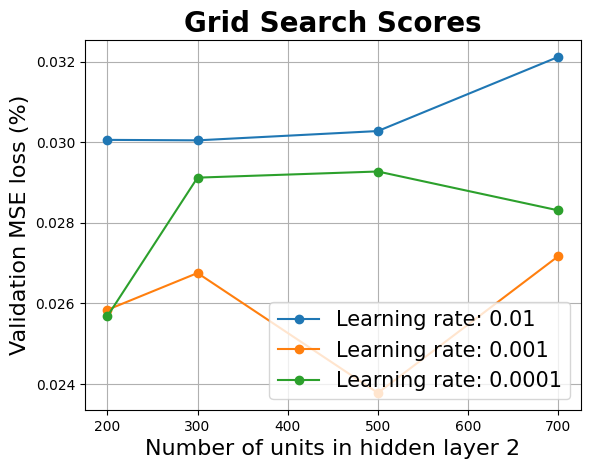

In [ ]:
#Print the parameters
column_names = ["Hidden layer1", "Hidden layer2", "Hidden layer3", "Kernel std", "Bias", "Output activation", "Learning rate", "Batch size", "Train loss", "Validation loss"]
df = pd.DataFrame (results, columns = column_names)
print(df)

#Plot the parameters
name_param_1 = "Number of units in hidden layer 2"
name_param_2 = "Learning rate"

grid_param_1 = []
for i in range(len(results)):
    grid_param_1.append(results[i][1])

grid_param_1 = np.array(grid_param_1)

grid_param_2 = []
for i in range(len(results)):
    grid_param_2.append(results[i][6])

grid_param_2 = np.array(grid_param_2)

scores = []
for i in range(len(results)):
    scores.append(results[i][-1])

scores = np.array(scores)

# Plot Grid search scores
_, ax = plt.subplots(1,1)

# Param1 is the X-axis, Param 2 is represented as a different curve (color line)

vals = learning_rate_vals
for i in range(len(vals)):
    index = np.where(np.array(grid_param_2) == vals[i])[0]
    ax.plot(grid_param_1[index], scores[index], '-o', label = name_param_2 + ': ' + str(vals[i]))

ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
ax.set_xlabel(name_param_1, fontsize=16)
ax.set_ylabel('Validation MSE loss (%)', fontsize=16)
ax.legend(loc="best", fontsize=15)
ax.grid('on')

plt.savefig("convergence")


Print the best parameters based on GridSearch results for minium validation loss (Look that if you want to get the model that generalizes the most)

In [ ]:
index = np.where(np.array(results)[:, -1] == min(np.array(results)[:, -1]))[0][0]
print("The minimum validation loss is ", results[index][-1])

best_hidden_layer_1 = results[index][0]
best_hidden_layer_2 = results[index][1]
best_hidden_layer_3 = results[index][2]
best_kernel_std = results[index][3]
best_bias = results[index][4]
best_output_activation = results[index][5]
best_learning_rate = results[index][6]
best_batch_size = results[index][7]


print("The optimal number of hidden units for hidden layer 1 is ", best_hidden_layer_1)
print("The optimal number of hidden units for hidden layer 2 is ", best_hidden_layer_2)
print("The optimal number of hidden units for hidden layer 3 is ", best_hidden_layer_3)
print("The optimal std for the weight initialization is ", best_kernel_std)
print("The optimal bias value is ", best_bias)
print("The optimal output activation function is ", best_output_activation)
print("The optimal learning rate size is ", best_learning_rate)
print("The optimal batch size is ", best_batch_size)

The minimum validation loss is  0.023774318397045135
The optimal number of hidden units for hidden layer 1 is  700
The optimal number of hidden units for hidden layer 2 is  500
The optimal number of hidden units for hidden layer 3 is  10
The optimal std for the weight initialization is  0.01
The optimal bias value is  0.0001
The optimal output activation function is  linear
The optimal learning rate size is  0.001
The optimal batch size is  32


Initialize the model using the best parameters based on GridSearch

In [ ]:
best_hidden_layers = [best_hidden_layer_1, best_hidden_layer_2, best_hidden_layer_3]

model=MLP(input_shape, best_hidden_layers, best_kernel_std, best_bias, best_output_activation, seed) # Model is initialized                    
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate = best_learning_rate), metrics=['mse']) # Model is compiled and the optimizer is being defined
model.summary() # Show the model structure

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 X_train (InputLayer)        [(None, 500)]             0         
                                                                 
 dense_65 (Dense)            (None, 700)               350700    
                                                                 
 dense_66 (Dense)            (None, 500)               350500    
                                                                 
 dense_67 (Dense)            (None, 10)                5010      
                                                                 
 dense_68 (Dense)            (None, 1)                 11        
                                                                 
Total params: 706,221
Trainable params: 706,221
Non-trainable params: 0
_________________________________________________________________


Train the model

Epoch 1/200
25/25 [==============================] - 1s 21ms/step - loss: 0.1752 - mse: 0.1752 - val_loss: 0.0742 - val_mse: 0.0742
Epoch 2/200
25/25 [==============================] - 0s 17ms/step - loss: 0.0521 - mse: 0.0521 - val_loss: 0.0542 - val_mse: 0.0542
Epoch 3/200
25/25 [==============================] - 0s 16ms/step - loss: 0.0439 - mse: 0.0439 - val_loss: 0.0506 - val_mse: 0.0506
Epoch 4/200
25/25 [==============================] - 0s 17ms/step - loss: 0.0417 - mse: 0.0417 - val_loss: 0.0476 - val_mse: 0.0476
Epoch 5/200
25/25 [==============================] - 0s 16ms/step - loss: 0.0401 - mse: 0.0401 - val_loss: 0.0472 - val_mse: 0.0472
Epoch 6/200
25/25 [==============================] - 0s 15ms/step - loss: 0.0377 - mse: 0.0377 - val_loss: 0.0471 - val_mse: 0.0471
Epoch 7/200
25/25 [==============================] - 0s 16ms/step - loss: 0.0366 - mse: 0.0366 - val_loss: 0.0433 - val_mse: 0.0433
Epoch 8/200
25/25 [==============================] - 0s 15ms/step - loss: 0.

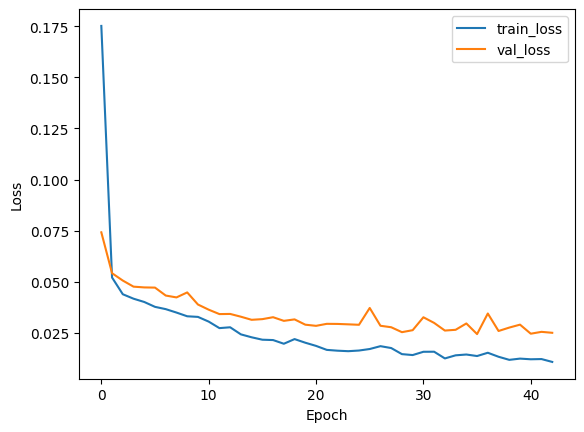

In [ ]:
time_start = time.time()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
history=model.fit([X_train], [y_train], epochs=200, batch_size=64, callbacks=[callback], validation_data=([X_val], [y_val]), verbose=1)

time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.legend()
plt.show()

## Test the model on unseen dataset

7/7 [==============================] - 0s 8ms/step
R2 scores: Train - 0.88410
R2 scores: Validation - 0.67685
R2 scores: Testing - 0.82349
RMSE scores: Train - 0.09752
RMSE scores: Validation - 0.15823
RMSE scores: Testing - 0.12785


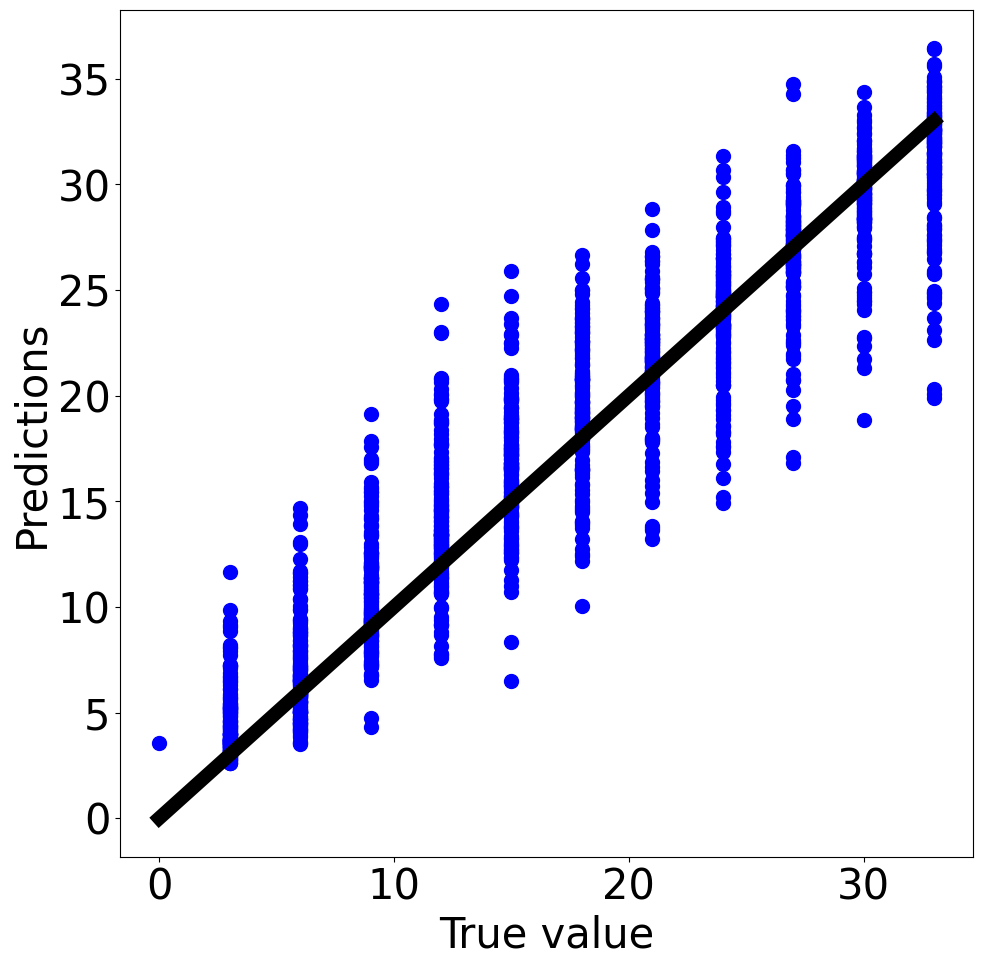

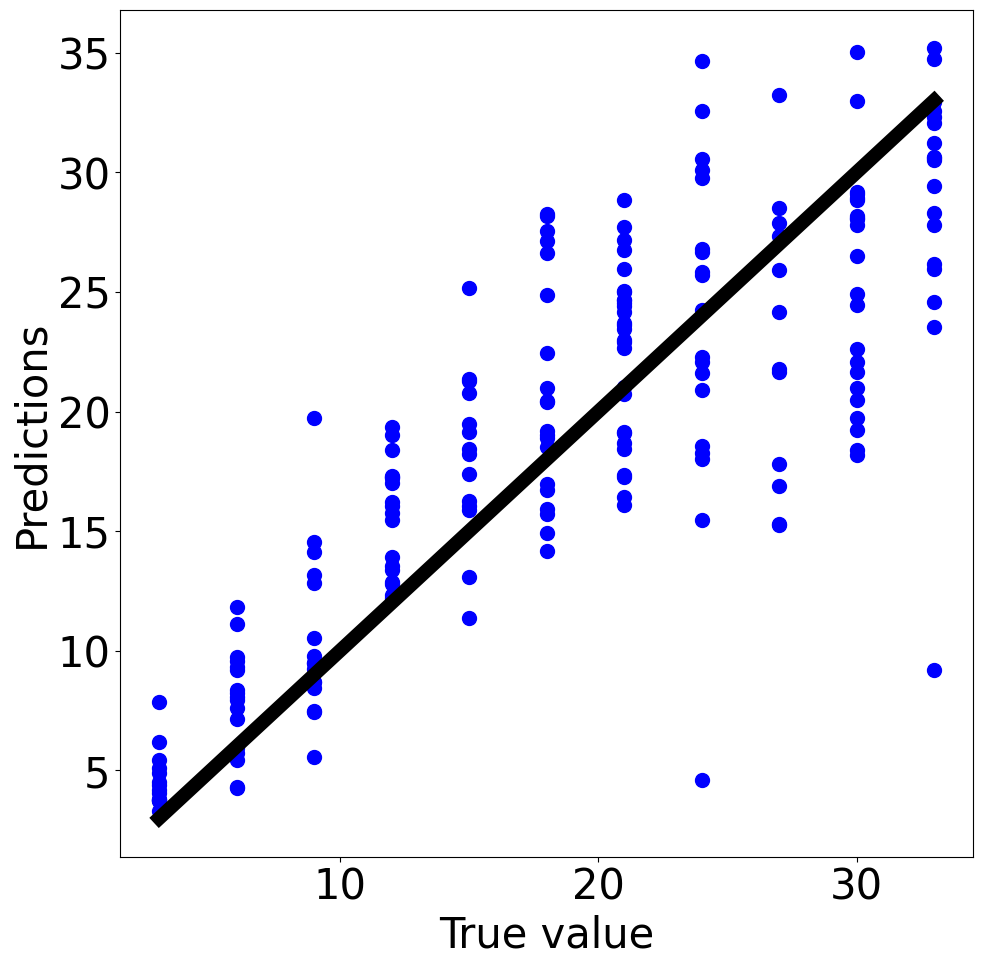

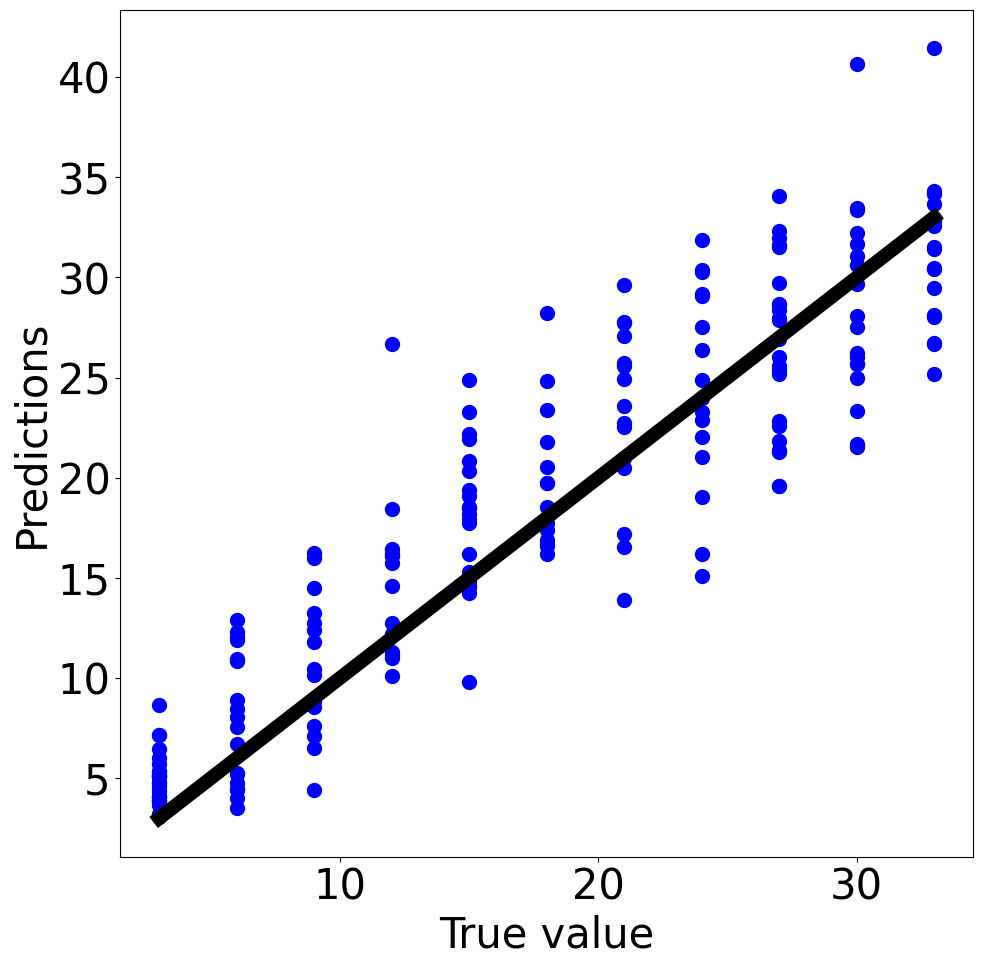

In [24]:
# Testing
predictions_train = model.predict(X_train)
r2_train = r2_score(y_train, predictions_train)
RMSE_train = np.sqrt(mean_squared_error(y_train, predictions_train))

predictions_val = model.predict(X_val)
r2_val = r2_score(y_val, predictions_val)
RMSE_val = np.sqrt(mean_squared_error(y_val, predictions_val))

predictions_test = model.predict(X_test)
r2_test = r2_score(y_test, predictions_test)
RMSE_test = np.sqrt(mean_squared_error(y_test, predictions_test))

# Print R2 Results
print("R2 scores: Train - %0.5f" %(r2_train))
print("R2 scores: Validation - %0.5f" %(r2_val))
print("R2 scores: Testing - %0.5f" %(r2_test))

# Print RSME Results
print("RMSE scores: Train - %0.5f" %(RMSE_train))
print("RMSE scores: Validation - %0.5f" %(RMSE_val))
print("RMSE scores: Testing - %0.5f" %(RMSE_test))


plt.figure(0, figsize =  (11, 11))
plt.scatter(scaler_y.inverse_transform(y_train), scaler_y.inverse_transform(predictions_train), s = 100, color = "blue")
plt.plot([min(scaler_y.inverse_transform(y_train)), max(scaler_y.inverse_transform(y_train))], [min(scaler_y.inverse_transform(y_train)), max(scaler_y.inverse_transform(y_train))], linewidth = 10, color = "black")
plt.xlabel("True value", fontsize = 30)
plt.ylabel("Predictions", fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=30)
#plt.title("Training dataset", fontsize = 30)
plt.savefig("Training.jpg", bbox_inches = "tight", dpi = 400)

plt.figure(1, figsize =  (11, 11))
plt.scatter(scaler_y.inverse_transform(y_val), scaler_y.inverse_transform(predictions_val), s = 100, color = "blue")
plt.plot([min(scaler_y.inverse_transform(y_val)), max(scaler_y.inverse_transform(y_val))], [min(scaler_y.inverse_transform(y_val)), max(scaler_y.inverse_transform(y_val))], linewidth = 10, color = "black")
plt.xlabel("True value", fontsize = 30)
plt.ylabel("Predictions", fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=30)
#plt.title("Validation dataset", fontsize = 30)
plt.savefig("Validation.jpg", bbox_inches = "tight", dpi = 400)

plt.figure(2, figsize =  (11, 11))
plt.scatter(scaler_y.inverse_transform(y_test), scaler_y.inverse_transform(predictions_test), s = 100, color = "blue")
plt.plot([min(scaler_y.inverse_transform(y_test)), max(scaler_y.inverse_transform(y_test))], [min(scaler_y.inverse_transform(y_test)), max(scaler_y.inverse_transform(y_test))], linewidth = 10, color = "black")
plt.xlabel("True value", fontsize = 30)
plt.ylabel("Predictions", fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=30)
#plt.title("Testing dataset", fontsize = 30)
plt.savefig("Testing.jpg", bbox_inches = "tight", dpi = 400)